## My Conv Net Interpretability

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy as sp

## Download and Prepare the Dataset

We will use the Cats vs Dogs dataset.  
The following will prepare the train, test, and eval sets.

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Preprocess the images and create batches before feeding it to our model.

In [3]:
IMAGE_SIZE = (224, 224)
def augment_images(image, label):
  
    # cast to float
    image = tf.cast(image, tf.float32)
    # normalize the pixel values
    image = (image/255)
    # resize to 224 x 224
    image = tf.image.resize(image,IMAGE_SIZE)

    return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)
augmented_validation_data = validation_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)
validation_batches = augmented_validation_data.shuffle(1024).batch(32)

## Modelling - VGG16

We will use a pre-trained VGG16 network as our base model for the classifier (Transfer learning). This will be followed by a global average pooling (GAP) and a 2-neuron Dense layer with softmax activation for the output. 
The earlier VGG blocks are frozen and we will just fine-tune the final layers during training. 

In [4]:
def VGG16():
    # load the base VGG16 model
    base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,), 
                      weights='imagenet', 
                      include_top=False)

    # add a GAP layer
    output = layers.GlobalAveragePooling2D()(base_model.output)

    # output has two neurons for the 2 classes (cats and dogs)
    output = layers.Dense(2, activation='softmax')(output)

    # set the inputs and outputs of the model
    model = Model(base_model.input, output)

    # freeze the earlier layers
    for layer in base_model.layers[:-4]:
        layer.trainable=False

    # choose the optimizer
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    # configure the model for training
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']) 

    # display the summary
    model.summary()

    return model

In [5]:
model = VGG16()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
EPOCHS = 5
model.fit(train_batches, epochs=EPOCHS ,validation_data=validation_batches)
model.save("vgg_trained.h5")

Epoch 1/5
582/582 [==============================] - 211s 359ms/step - loss: 0.2167 - accuracy: 0.9282 - val_loss: 0.2764 - val_accuracy: 0.8955
Epoch 2/5
582/582 [==============================] - 212s 361ms/step - loss: 0.1542 - accuracy: 0.9504 - val_loss: 0.1345 - val_accuracy: 0.9377
Epoch 3/5
582/582 [==============================] - 210s 358ms/step - loss: 0.1240 - accuracy: 0.9581 - val_loss: 0.1461 - val_accuracy: 0.9484
Epoch 4/5
582/582 [==============================] - 209s 356ms/step - loss: 0.1108 - accuracy: 0.9654 - val_loss: 0.1284 - val_accuracy: 0.9514
Epoch 5/5
582/582 [==============================] - 210s 357ms/step - loss: 0.0883 - accuracy: 0.9728 - val_loss: 0.4698 - val_accuracy: 0.9089


### Class Activation Map: 

Retrieve the weights of the global_average_pooling2d, there are number of weights as the number of features for each label - in this case 512 features for cat and 512 for dog. 

In [7]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(512, 2)

Define the Class Activation Map (CAM) model. The model outputs 2 outputs: the classification output (cat/dog) and the last conv layer before maxpooling (block5_conv3) this is the last embeding layer. 

In [8]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-4].output,model.layers[-1].output))

Compute the CAM by upscaling the feature layer (block5_conv3) to the real image size and calculate the dot product between the upsampled feature layer and the weight vector:

[14 x 14 x 512] -> upscaling -> [224 x 224 x 512] -> dot product with [512 x 1] -> CAM size = [224 x 224 x 1] 

In [9]:
def show_cam(image_value, features, results):
    '''
    Displays the class activation map of an image

    Args:
    image_value (tensor) -- preprocessed input image with size 224 x 224
    features (array) -- features of the image, shape (1, 14, 14, 512)
    results (array) -- output of the sigmoid layer
    '''

    # there is only one image in the batch so we index at `0`
    features_for_img = features[0]
    prediction = results[0]

    # compute the upscale ratio:
    upscale_ratio = IMAGE_SIZE[0]/features_for_img.shape[0]

    # select the wheights according to the classification - 1 for cat and 0 for dog:
    if round(results[0][0]):
        class_activation_weights = gap_weights[:,1]
    else: 
        class_activation_weights = gap_weights[:,0]

    # upsample to the image size
    class_activation_features = sp.ndimage.zoom(features_for_img, (upscale_ratio, upscale_ratio, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    # visualize the results
    print(f'softmax output: {results}')
    print(f"prediction: {'cat' if round(results[0][0]) else 'dog'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.axis('off')
    plt.show()


Helper function for preproccesing the image to infere in the model 

In [10]:
def preproccess_image(image):
    # load the image
    img = cv2.imread(image)

    # preprocess the image before feeding it to the model
    img = cv2.resize(img, IMAGE_SIZE) / 255.0

    # add a batch dimension because the model expects it
    tensor_image = np.expand_dims(img, axis=0)

    return tensor_image, img


Main function that wraps up all the procces, from preproccessing the image, forwardprop in the model, compute CAM and display over the image.

In the example below the model recognize my cat Kelly as a "cat" and the CAM shows that the main feature is her nose. 

softmax output: [[1.000000e+00 2.632198e-30]]
prediction: cat


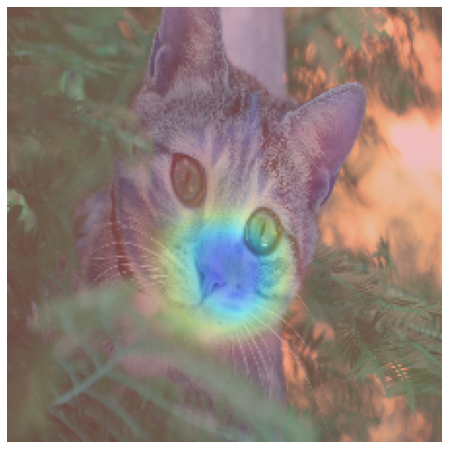

In [11]:
# utility function to preprocess an image and show the CAM
def convert_and_classify_CAM(image):
    tensor_image, _ = preproccess_image(image)

    # get the features and prediction
    features,results = cam_model.predict(tensor_image)

    # generate the CAM
    show_cam(tensor_image, features, results)

convert_and_classify_CAM('Kelly.JPG')


## Saliency Map:
Compute Gradients:

Get the gradients of the loss with respect to the input image pixels. This is the key step to generate the saliency map. It can indicate when certain parts of the input image have a significant effect on the categorical prediction.

In [12]:
def Saliency_gradients(tensor_image, class_index = 0):
    # class_index = 0 for cat and 1 for dog - need to change according to image

    # number of classes in the model's training data
    num_classes = 2

    # convert to one hot representation to match our softmax activation in the model definition
    expected_output = tf.one_hot([class_index] * tensor_image.shape[0], num_classes)

    with tf.GradientTape() as tape:
        # cast image to float
        inputs = tf.cast(tensor_image, tf.float32)

        # watch the input pixels
        tape.watch(inputs)

        # generate the predictions
        predictions = model(inputs)

        # get the loss
        loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)    
      
    # get the gradient with respect to the inputs
    gradients = tape.gradient(loss, inputs)

    return gradients

Proccess Saliency map and display it alone and over the image: 

In [13]:
def show_Saliency(gradients, img): 
    # reduce the RGB image to grayscale
    grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

    # normalize the pixel values to be in the range [0, 255].
    # the max value in the grayscale tensor will be pushed to 255.
    # the min value will be pushed to 0.
    normalized_tensor = tf.cast(
      255
      * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
      / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
      tf.uint8,
    )

    # remove the channel dimension to make the tensor a 2d tensor
    normalized_tensor = tf.squeeze(normalized_tensor)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(normalized_tensor, cmap='gray')
    plt.show()

    gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
    gradient_color = gradient_color / 255.0
    super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

    plt.figure(figsize=(8, 8))
    plt.imshow(super_imposed)
    plt.axis('off')
    plt.show()

Function to preprocess an image and show the Saliency map:

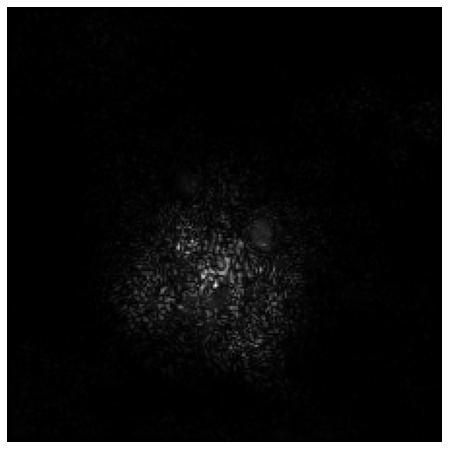

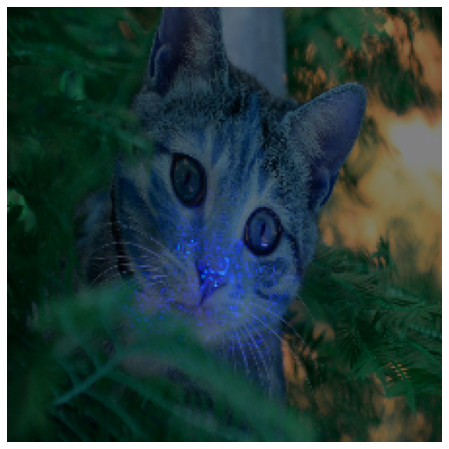

In [14]:
# utility function to preprocess an image and show the CAM
def convert_and_classify_Saliency(image):

    tensor_image, img = preproccess_image(image)

    gradients = Saliency_gradients(tensor_image, class_index = 0)

    show_Saliency(gradients, img)

convert_and_classify_Saliency('Kelly.JPG')
